In [1]:
import os
import torch
from torch.utils.data import Dataset
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import timedelta, datetime
from matplotlib.animation import FuncAnimation
from pysteps.visualization import plot_precip_field

/opt/anacondas/anaconda3/envs/nowcasting/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pysteps configuration file found at: /opt/anacondas/anaconda3/envs/nowcasting/lib/python3.10/site-packages/pysteps/pystepsrc



## Accuracy of models throughout leadtimes

In [2]:
# load paths dates and target indices
ta_path = '/data/maly_javornik_CMAX_60k_2/maly_javornik_new_sampling/{y:04}{m:02}{d:02}{h:02}{min:02}.h5'
lc_path = '/data/softec-lagrangian-nowcasting/outputs/lagrangian/lcnn-bugfix_v2/lcnn-bugfix.h5'
nn_path = '/data/softec-lagrangian-nowcasting/outputs/RainNet/RainNet-iterative.h5'
lupin_path = '/data/softec-lagrangian-nowcasting/outputs/LUPIN-diff-finetune-rmse/LLUPIN-diff-pretrain-rmse-finetune.h5'

with h5py.File('/data/maly_javornik_CMAX_60k_2/maly_javornik_new_sampling/metadata.h5', 'r') as hf:
    date_list = [item.decode() for item in hf['timestamps'][()]]
    date_list = np.array([datetime.strptime(item, '%Y-%m-%dT%H:%M:%S.%fZ') for item in date_list])
with h5py.File('/data/maly_javornik_CMAX_60k_2/maly_javornik_new_sampling/metadata_lcnn_test.h5', 'r') as hf:
    targets = np.array(hf['target_idx'])
targets = targets[12:len(targets)]

In [3]:
def arr_reconstruct_uint8(
    uint8_array: np.ndarray, missing_val: np.uint8 = 255, undetect_val: np.uint8 = 0, mask_val: float = np.nan, mask2_val: float = 64.0
):
    mask = uint8_array == missing_val
    mask2 = uint8_array == undetect_val
    arr = uint8_array.astype(np.float64)
    arr[mask] = mask_val
    arr[mask2] = mask2_val
    arr = (arr - 64) / 2.0
    return arr

def dbztommh(data):
    data = 10 ** (data * 0.1)
    data = (data / 200) ** (1 / 1.6)
    return data

In [10]:
# camfulate MAE and ME and MSE
leadtimes = range(6)

def MSE(A, B):
    return np.nanmean((A - B)**2, axis=None)
def MAE(A, B):
    return np.nanmean(np.abs(A - B), axis=None)
def ME(A, B):
    return np.nanmean(A - B, axis=None)
            

tot_MAE_nn = np.zeros((len(targets),6), dtype=np.float64)
tot_ME_nn = np.zeros((len(targets),6), dtype=np.float64)
tot_MSE_nn = np.zeros((len(targets),6), dtype=np.float64)
tot_MAE_lc = np.zeros((len(targets),6), dtype=np.float64)
tot_ME_lc = np.zeros((len(targets),6), dtype=np.float64)
tot_MSE_lc = np.zeros((len(targets),6), dtype=np.float64)
tot_MAE_lupin = np.zeros((len(targets),6), dtype=np.float64)
tot_ME_lupin = np.zeros((len(targets),6), dtype=np.float64)
tot_MSE_lupin = np.zeros((len(targets),6), dtype=np.float64)

with h5py.File(lc_path, 'r') as lf, h5py.File(nn_path, 'r') as nf, h5py.File(lupin_path, 'r') as lupin:    
    for i, idx in enumerate(targets):
        date = date_list[idx]
        date_lagged = date - timedelta(minutes=30)
        
        lc_group_date = lf.require_group(datetime.strftime(date_lagged, '%Y-%m-%d %H:%M:%S'))
        nn_group_date = nf.require_group(datetime.strftime(date_lagged, '%Y-%m-%d %H:%M:%S'))
        lupin_group_date = lupin.require_group(datetime.strftime(date_lagged, '%Y-%m-%d %H:%M:%S'))

        lc_group_method = lc_group_date.require_group('model')
        nn_group_method = nn_group_date.require_group('model')
        lupin_group_method = lupin_group_date.require_group('model')
        
        for leadtime in leadtimes:
            target_date_lagged = date - timedelta(minutes=25-leadtime*5)
            target = h5py.File(ta_path.format(y=target_date_lagged.year, m=target_date_lagged.month, d=target_date_lagged.day, h=target_date_lagged.hour, min=target_date_lagged.minute), 'r')['precipitation_map']
            target = target[2:338,2:338][45:291, 45:291]
            
            lc_group_leadtime = lc_group_method.require_group(str(leadtime+1))
            nn_group_leadtime = nn_group_method.require_group(str(leadtime+1))
            lupin_group_leadtime = lupin_group_method.require_group(str(leadtime+1))

            output_lc = arr_reconstruct_uint8(lc_group_leadtime['data'][()])
            output_nn = arr_reconstruct_uint8(nn_group_leadtime['data'][()])
            output_lupin = arr_reconstruct_uint8(lupin_group_leadtime['data'][()])


            cut_output_lc = output_lc[45:291, 45:291]
            cut_output_nn = output_nn[45:291, 45:291]
            cut_output_lupin = output_lupin[45:291, 45:291]

            cut_output_lc = dbztommh(cut_output_lc)
            cut_output_nn = dbztommh(cut_output_nn)
            cut_output_lupin = dbztommh(cut_output_lupin)
            target = dbztommh(target)

            tot_MAE_nn[i, leadtime] = MAE(target, cut_output_nn)
            tot_ME_nn[i, leadtime] = ME(target, cut_output_nn)
            tot_MSE_nn[i, leadtime] = MSE(target, cut_output_nn)
            tot_MAE_lc[i, leadtime] = MAE(target, cut_output_lc)
            tot_ME_lc[i, leadtime] = ME(target, cut_output_lc)
            tot_MSE_lc[i, leadtime] = MSE(target, cut_output_lc)
            tot_MAE_lupin[i, leadtime] = MAE(target, cut_output_lupin)
            tot_ME_lupin[i, leadtime] = ME(target, cut_output_lupin)
            tot_MSE_lupin[i, leadtime] = MSE(target, cut_output_lupin)
        
        if (i % 200 == 0):
            print(f'{i} out of {len(targets)} done.')

0 out of 10944 done.
200 out of 10944 done.
400 out of 10944 done.
600 out of 10944 done.
800 out of 10944 done.
1000 out of 10944 done.
1200 out of 10944 done.
1400 out of 10944 done.
1600 out of 10944 done.
1800 out of 10944 done.
2000 out of 10944 done.
2200 out of 10944 done.
2400 out of 10944 done.
2600 out of 10944 done.
2800 out of 10944 done.
3000 out of 10944 done.
3200 out of 10944 done.
3400 out of 10944 done.
3600 out of 10944 done.
3800 out of 10944 done.
4000 out of 10944 done.
4200 out of 10944 done.
4400 out of 10944 done.
4600 out of 10944 done.
4800 out of 10944 done.
5000 out of 10944 done.
5200 out of 10944 done.
5400 out of 10944 done.
5600 out of 10944 done.
5800 out of 10944 done.
6000 out of 10944 done.
6200 out of 10944 done.
6400 out of 10944 done.
6600 out of 10944 done.
6800 out of 10944 done.
7000 out of 10944 done.
7200 out of 10944 done.
7400 out of 10944 done.
7600 out of 10944 done.
7800 out of 10944 done.
8000 out of 10944 done.
8200 out of 10944 done.

In [12]:
MAE_nn = np.mean(tot_MAE_nn, axis=0)
ME_nn = np.mean(tot_ME_nn, axis=0)
MSE_nn = np.mean(tot_MSE_nn, axis=0)
MAE_lc = np.mean(tot_MAE_lc, axis=0)
ME_lc = np.mean(tot_ME_lc, axis=0)
MSE_lc = np.mean(tot_MSE_lc, axis=0)
MAE_lupin = np.mean(tot_MAE_lupin, axis=0)
ME_lupin = np.mean(tot_ME_lupin, axis=0)
MSE_lupin = np.mean(tot_MSE_lupin, axis=0)

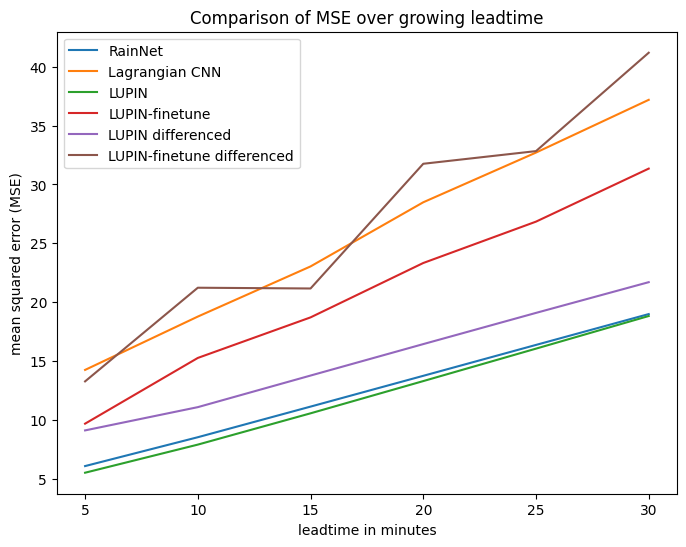

In [6]:
# MSE plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(6,4))

plt.plot(x, MSE_nn, '-', label='RainNet')
plt.plot(x, MSE_lc, label='Lagrangian CNN')
plt.plot(x, MSE_lupin, label='LUPIN')
  
plt.xlabel("leadtime in minutes")
plt.ylabel("mean squared error (MSE)")
plt.title('Comparison of MSE over growing leadtime')
plt.legend(loc="upper left")
# plt.yscale('log')
plt.show()

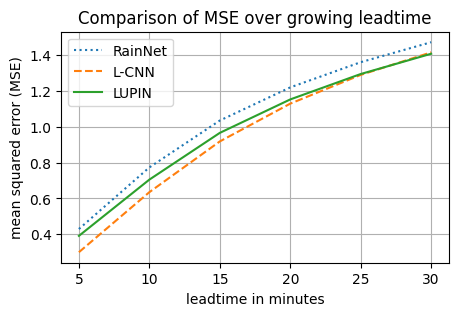

In [70]:
# MSE plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(5,3))

plt.plot(x, MSE_nn, ':', label='RainNet')
plt.plot(x, MSE_lc, '--', label='L-CNN')
plt.plot(x, MSE_lupin, label='LUPIN')

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("mean squared error (MSE)")
plt.title('Comparison of MSE over growing leadtime')
plt.legend(loc="upper left")
# plt.yscale('log')
plt.savefig("mse.pdf", bbox_inches='tight')

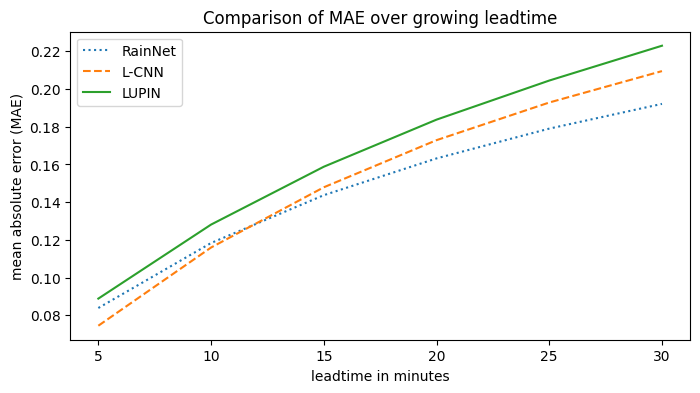

In [22]:
# MAE plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(8,4))

plt.plot(x, MAE_nn, ':', label='RainNet')
plt.plot(x, MAE_lc, '--', label='L-CNN')
plt.plot(x, MAE_lupin, label='LUPIN')
  
plt.xlabel("leadtime in minutes")
plt.ylabel("mean absolute error (MAE)")
plt.title('Comparison of MAE over growing leadtime')
plt.legend(loc="upper left")
plt.show()

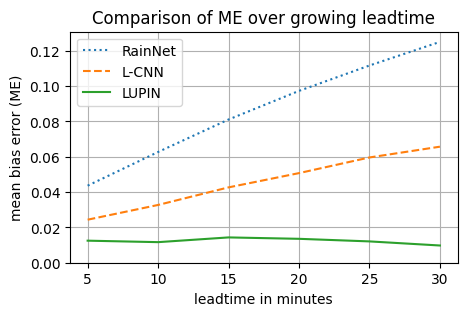

In [69]:
# ME plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(5,3))

plt.plot(x, ME_nn, ':', label='RainNet')
plt.plot(x, ME_lc, '--', label='L-CNN')
plt.plot(x, ME_lupin, label='LUPIN')

ax = plt.gca()
ax.set_ylim(0)

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("mean bias error (ME)")
plt.title('Comparison of ME over growing leadtime')
plt.legend(loc="upper left")
plt.savefig("me.pdf", bbox_inches='tight')

In [32]:
# calculate elements of confusion matrix
leadtimes = range(6)
thresholds = [1, 5, 10]

def get_conf_mat(pred, target, threshold):
    pred_mask = pred.flatten() > threshold
    target_mask = target.flatten() > threshold
    tn, fp, fn, tp = np.bincount(target_mask*2 + pred_mask, minlength=4)
    return tn, fp, fn, tp

def get_disc_metrics(tn, fp, fn, tp):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    a_r = ((tp + fp) * (tp + fn))/(tp + fp + tn + fn)
    ets = (tp - a_r)/(tp + fp + fn - a_r)
    far = fp / (tp + fp)
    return precision, recall, accuracy, ets, far    
            
tot_tn_sp = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_fp_sp = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_fn_sp = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_tp_sp = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_tn_ep = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_fp_ep = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_fn_ep = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_tp_ep = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_tn_nn = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_fp_nn = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_fn_nn = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_tp_nn = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_tn_lc = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_fp_lc = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_fn_lc = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_tp_lc = np.zeros((len(thresholds), 6), dtype=np.float64)

tot_tn_mf = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_fp_mf = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_fn_mf = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_tp_mf = np.zeros((len(thresholds), 6), dtype=np.float64)

tot_tn_lupin = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_fp_lupin = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_fn_lupin = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_tp_lupin = np.zeros((len(thresholds), 6), dtype=np.float64)

tot_tn_lupin_ft = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_fp_lupin_ft = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_fn_lupin_ft = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_tp_lupin_ft = np.zeros((len(thresholds), 6), dtype=np.float64)

tot_tn_lupin_diff = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_fp_lupin_diff = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_fn_lupin_diff = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_tp_lupin_diff = np.zeros((len(thresholds), 6), dtype=np.float64)

tot_tn_lupin_ft_diff = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_fp_lupin_ft_diff = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_fn_lupin_ft_diff = np.zeros((len(thresholds), 6), dtype=np.float64)
tot_tp_lupin_ft_diff = np.zeros((len(thresholds), 6), dtype=np.float64)

with h5py.File(lc_path, 'r') as lf, h5py.File(nn_path, 'r') as nf, h5py.File(lupin_path, 'r') as lupin:    
    for i, idx in enumerate(targets):
        date = date_list[idx]
        date_lagged = date - timedelta(minutes=30)
        
        lc_group_date = lf.require_group(datetime.strftime(date_lagged, '%Y-%m-%d %H:%M:%S'))
        nn_group_date = nf.require_group(datetime.strftime(date_lagged, '%Y-%m-%d %H:%M:%S'))
        lupin_group_date = lupin.require_group(datetime.strftime(date_lagged, '%Y-%m-%d %H:%M:%S'))

        lc_group_method = lc_group_date.require_group('model')
        nn_group_method = nn_group_date.require_group('model')
        lupin_group_method = lupin_group_date.require_group('model')

        for leadtime in leadtimes:
            target_date_lagged = date - timedelta(minutes=25-leadtime*5)
            target = h5py.File(ta_path.format(y=target_date_lagged.year, m=target_date_lagged.month, d=target_date_lagged.day, h=target_date_lagged.hour, min=target_date_lagged.minute), 'r')['precipitation_map']
            target = target[2:338,2:338][45:291, 45:291]
            
            lc_group_leadtime = lc_group_method.require_group(str(leadtime+1))
            nn_group_leadtime = nn_group_method.require_group(str(leadtime+1))
            lupin_group_leadtime = lupin_group_method.require_group(str(leadtime+1))

            output_lc = arr_reconstruct_uint8(lc_group_leadtime['data'][()])
            output_nn = arr_reconstruct_uint8(nn_group_leadtime['data'][()])
            output_lupin = arr_reconstruct_uint8(lupin_group_leadtime['data'][()])

            output_lc = dbztommh(output_lc)
            output_nn = dbztommh(output_nn)
            output_lupin = dbztommh(output_lupin)
            target = dbztommh(target)

            for j, threshold in enumerate(thresholds):
                tn, fp, fn, tp = get_conf_mat(output_nn[45:291, 45:291], target, threshold)
                tot_tn_nn[j, leadtime] += tn
                tot_fp_nn[j, leadtime] += fp
                tot_fn_nn[j, leadtime] += fn
                tot_tp_nn[j, leadtime] += tp
                
                tn, fp, fn, tp = get_conf_mat(output_lc[45:291, 45:291], target, threshold)
                tot_tn_lc[j, leadtime] += tn
                tot_fp_lc[j, leadtime] += fp
                tot_fn_lc[j, leadtime] += fn
                tot_tp_lc[j, leadtime] += tp

                tn, fp, fn, tp = get_conf_mat(output_lupin[45:291, 45:291], target, threshold)
                tot_tn_lupin[j, leadtime] += tn
                tot_fp_lupin[j, leadtime] += fp
                tot_fn_lupin[j, leadtime] += fn
                tot_tp_lupin[j, leadtime] += tp
                
        if (i % 500 == 0):
            print(f'{i} out of {len(targets)} done.')
        

0 out of 10944 done.
500 out of 10944 done.
1000 out of 10944 done.
1500 out of 10944 done.
2000 out of 10944 done.
2500 out of 10944 done.
3000 out of 10944 done.
3500 out of 10944 done.
4000 out of 10944 done.
4500 out of 10944 done.
5000 out of 10944 done.
5500 out of 10944 done.
6000 out of 10944 done.
6500 out of 10944 done.
7000 out of 10944 done.
7500 out of 10944 done.
8000 out of 10944 done.
8500 out of 10944 done.
9000 out of 10944 done.
9500 out of 10944 done.
10000 out of 10944 done.
10500 out of 10944 done.


In [71]:
def get_disc_metrics(tn, fp, fn, tp):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    a_r = ((tp + fp) * (tp + fn))/(tp + fp + tn + fn)
    ets = (tp - a_r)/(tp + fp + fn - a_r)
    far = fp / (tp + fp)
    csi = tp / (tp + fn + fp)
    return precision, recall, accuracy, ets, far, csi  

precision_nn = np.zeros((len(thresholds), 6), dtype=np.float64)
recall_nn = np.zeros((len(thresholds), 6), dtype=np.float64)
accuracy_nn = np.zeros((len(thresholds), 6), dtype=np.float64)
ets_nn = np.zeros((len(thresholds), 6), dtype=np.float64)
far_nn = np.zeros((len(thresholds), 6), dtype=np.float64)
csi_nn = np.zeros((len(thresholds), 6), dtype=np.float64)

precision_lc = np.zeros((len(thresholds), 6), dtype=np.float64)
recall_lc = np.zeros((len(thresholds), 6), dtype=np.float64)
accuracy_lc = np.zeros((len(thresholds), 6), dtype=np.float64)
ets_lc = np.zeros((len(thresholds), 6), dtype=np.float64)
far_lc = np.zeros((len(thresholds), 6), dtype=np.float64)
csi_lc = np.zeros((len(thresholds), 6), dtype=np.float64)

precision_lupin = np.zeros((len(thresholds), 6), dtype=np.float64)
recall_lupin = np.zeros((len(thresholds), 6), dtype=np.float64)
accuracy_lupin = np.zeros((len(thresholds), 6), dtype=np.float64)
ets_lupin = np.zeros((len(thresholds), 6), dtype=np.float64)
far_lupin = np.zeros((len(thresholds), 6), dtype=np.float64)
csi_lupin = np.zeros((len(thresholds), 6), dtype=np.float64)

for i in range(len(thresholds)):
    for j in range(len(leadtimes)):
        precision_lc[i, j], recall_lc[i, j], accuracy_lc[i, j], ets_lc[i, j], far_lc[i, j], csi_lc[i, j] = get_disc_metrics(tot_tn_lc[i,j], tot_fp_lc[i,j], tot_fn_lc[i,j], tot_tp_lc[i,j])
        precision_nn[i, j], recall_nn[i, j], accuracy_nn[i, j], ets_nn[i, j], far_nn[i, j], csi_nn[i, j] = get_disc_metrics(tot_tn_nn[i,j], tot_fp_nn[i,j], tot_fn_nn[i,j], tot_tp_nn[i,j])
        precision_lupin[i, j], recall_lupin[i, j], accuracy_lupin[i, j], ets_lupin[i, j], far_lupin[i, j], csi_lupin[i, j] = get_disc_metrics(tot_tn_lupin[i,j], tot_fp_lupin[i,j], tot_fn_lupin[i,j], tot_tp_lupin[i,j])

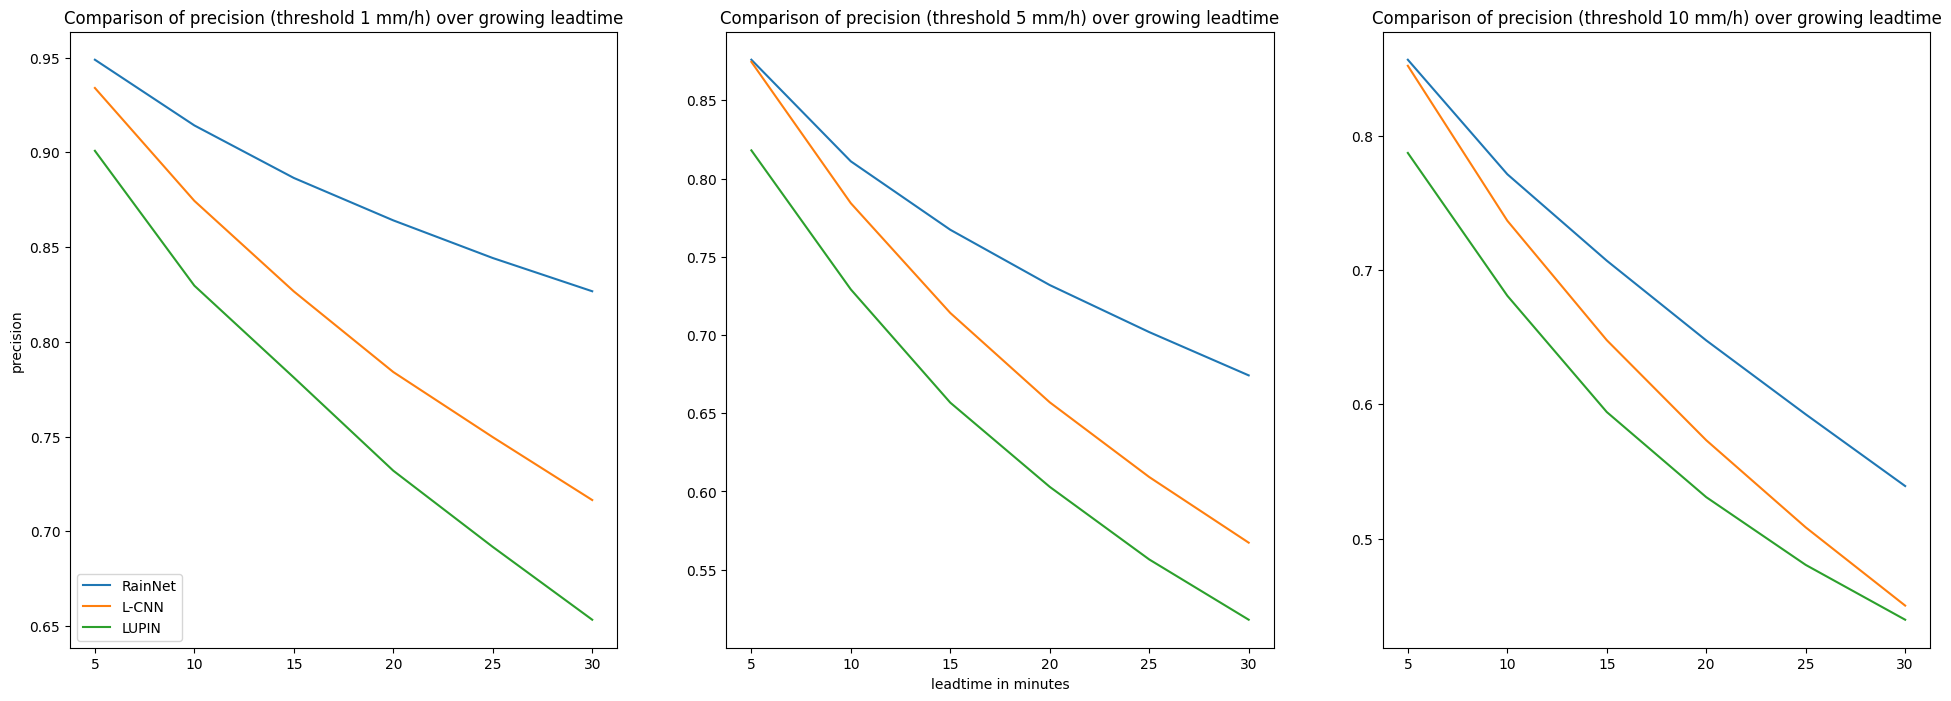

In [36]:
# precision plot
%matplotlib inline
thresholds_mmh = [1, 5, 10]
x = [5,10,15,20,25,30]
fig, axes = plt.subplots(figsize=(24,8), nrows=1, ncols=3, gridspec_kw={'width_ratios': [8,8,8]})
for i, ax in enumerate(axes):
    ax.plot(x, precision_nn[i,:], '-', label='RainNet')
    ax.plot(x, precision_lc[i,:], label='L-CNN')
    ax.plot(x, precision_lupin[i,:], label='LUPIN')

    ax.set_title(f'Comparison of precision (threshold {thresholds_mmh[i]} mm/h) over growing leadtime')

axes[0].set_ylabel("precision")  
axes[0].legend(loc="lower left")
axes[1].set_xlabel("leadtime in minutes")
plt.show()

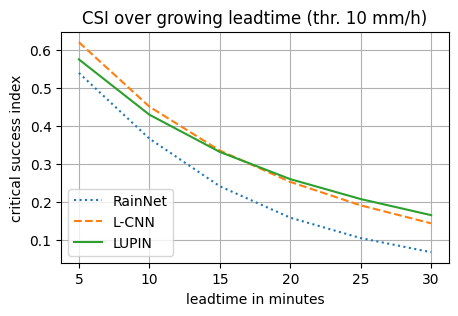

In [74]:
# ME plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(5,3))

plt.plot(x, csi_nn[2], ':', label='RainNet')
plt.plot(x, csi_lc[2], '--', label='L-CNN')
plt.plot(x, csi_lupin[2], label='LUPIN')

ax = plt.gca()

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("critical success index")
plt.title('CSI over growing leadtime (thr. 10 mm/h)')
plt.legend(loc="lower left")
plt.savefig("csi.pdf", bbox_inches='tight')

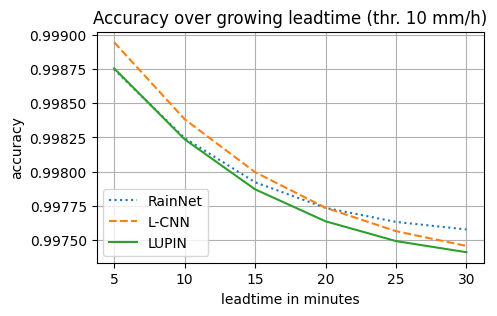

In [75]:
# ME plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(5,3))

plt.plot(x, accuracy_nn[2], ':', label='RainNet')
plt.plot(x, accuracy_lc[2], '--', label='L-CNN')
plt.plot(x, accuracy_lupin[2], label='LUPIN')

ax = plt.gca()

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("accuracy")
plt.title('Accuracy over growing leadtime (thr. 10 mm/h)')
plt.legend(loc="lower left")
plt.savefig("accuracy.pdf", bbox_inches='tight')

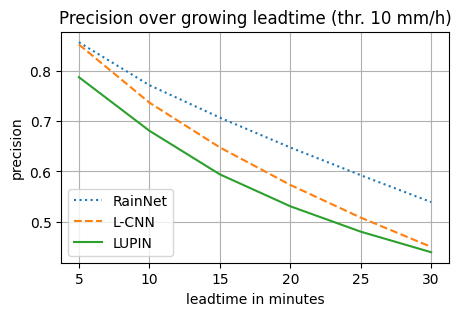

In [65]:
# ME plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(5,3))

plt.plot(x, precision_nn[2], ':', label='RainNet')
plt.plot(x, precision_lc[2], '--', label='L-CNN')
plt.plot(x, precision_lupin[2], label='LUPIN')

ax = plt.gca()

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("precision")
plt.title('Precision over growing leadtime (thr. 10 mm/h)')
plt.legend(loc="lower left")
plt.savefig("precision.pdf", bbox_inches='tight')

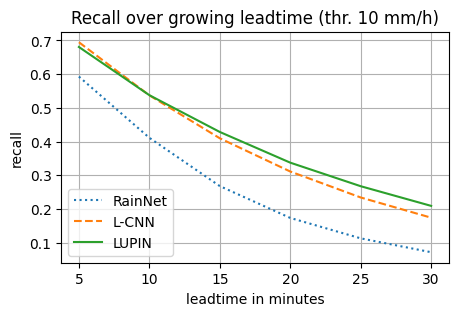

In [66]:
# ME plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(5,3))

plt.plot(x, recall_nn[2], ':', label='RainNet')
plt.plot(x, recall_lc[2], '--', label='L-CNN')
plt.plot(x, recall_lupin[2], label='LUPIN')

ax = plt.gca()

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("recall")
plt.title('Recall over growing leadtime (thr. 10 mm/h)')
plt.legend(loc="lower left")
plt.savefig("recall.pdf", bbox_inches='tight')

In [83]:
(recall_lupin[2][-1] / recall_lc[2][-1] - 1) * 100

20.056568995105817

In [84]:
(ets_lupin[2][-1] / ets_lc[2][-1] - 1) * 100

14.951193631760828

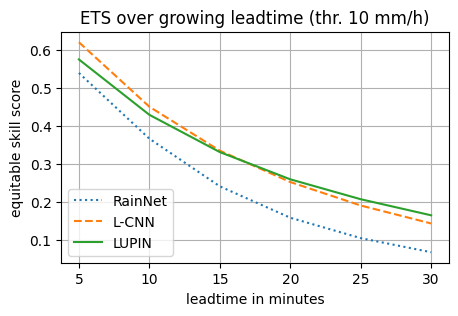

In [67]:
# ME plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(5,3))

plt.plot(x, ets_nn[2], ':', label='RainNet')
plt.plot(x, ets_lc[2], '--', label='L-CNN')
plt.plot(x, ets_lupin[2], label='LUPIN')

ax = plt.gca()

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("equitable skill score")
plt.title('ETS over growing leadtime (thr. 10 mm/h)')
plt.legend(loc="lower left")
plt.savefig("ets.pdf", bbox_inches='tight')

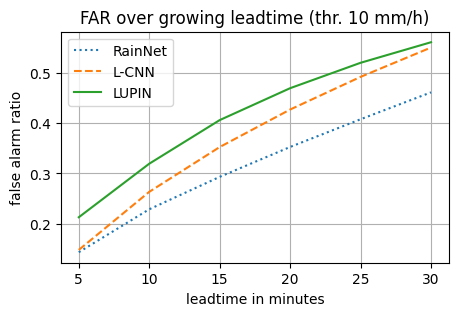

In [68]:
# ME plot
%matplotlib inline
x = [5,10,15,20,25,30]

plt.figure(figsize=(5,3))

plt.plot(x, far_nn[2], ':', label='RainNet')
plt.plot(x, far_lc[2], '--', label='L-CNN')
plt.plot(x, far_lupin[2], label='LUPIN')

ax = plt.gca()

plt.grid()
  
plt.xlabel("leadtime in minutes")
plt.ylabel("false alarm ratio")
plt.title('FAR over growing leadtime (thr. 10 mm/h)')
plt.legend(loc="upper left")
plt.savefig("far.pdf", bbox_inches='tight')

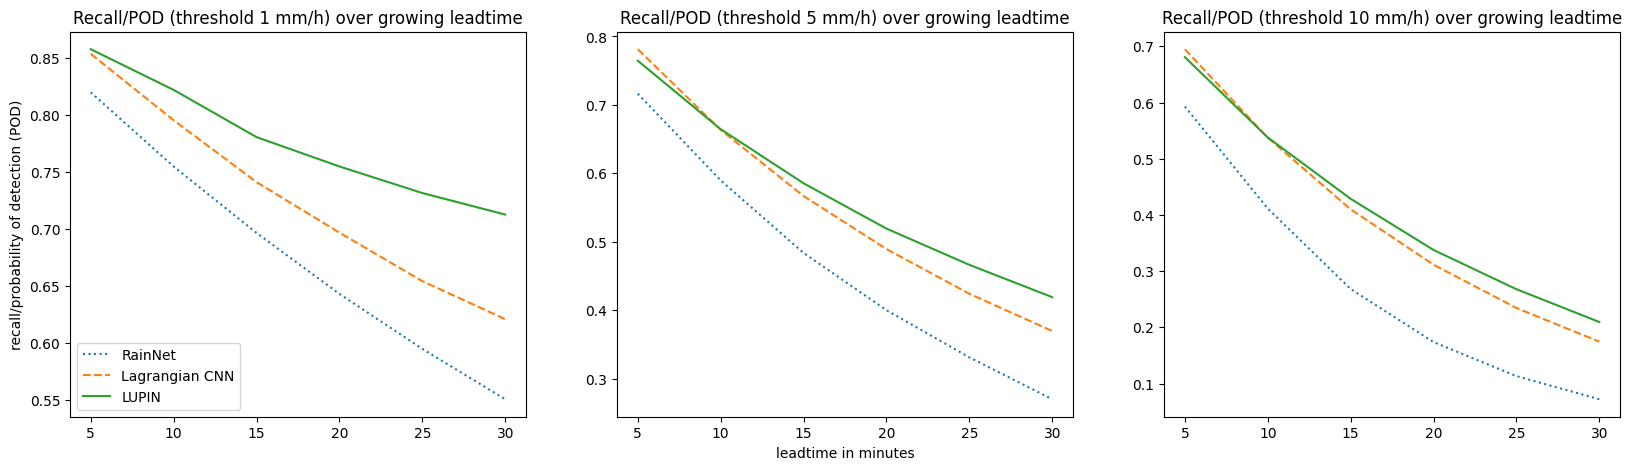

In [48]:
# recall/POD plot
%matplotlib inline
x = [5,10,15,20,25,30]
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=3, gridspec_kw={'width_ratios': [8,8,8]})
for i, ax in enumerate(axes):
    ax.plot(x, recall_nn[i,:], ':', label='RainNet')
    ax.plot(x, recall_lc[i,:], '--', label='Lagrangian CNN')
    ax.plot(x, recall_lupin[i,:], label='LUPIN')

    ax.set_title(f'Recall/POD (threshold {thresholds_mmh[i]} mm/h) over growing leadtime')

axes[0].set_ylabel("recall/probability of detection (POD)")  
axes[0].legend(loc="lower left")
axes[1].set_xlabel("leadtime in minutes")    
plt.show()

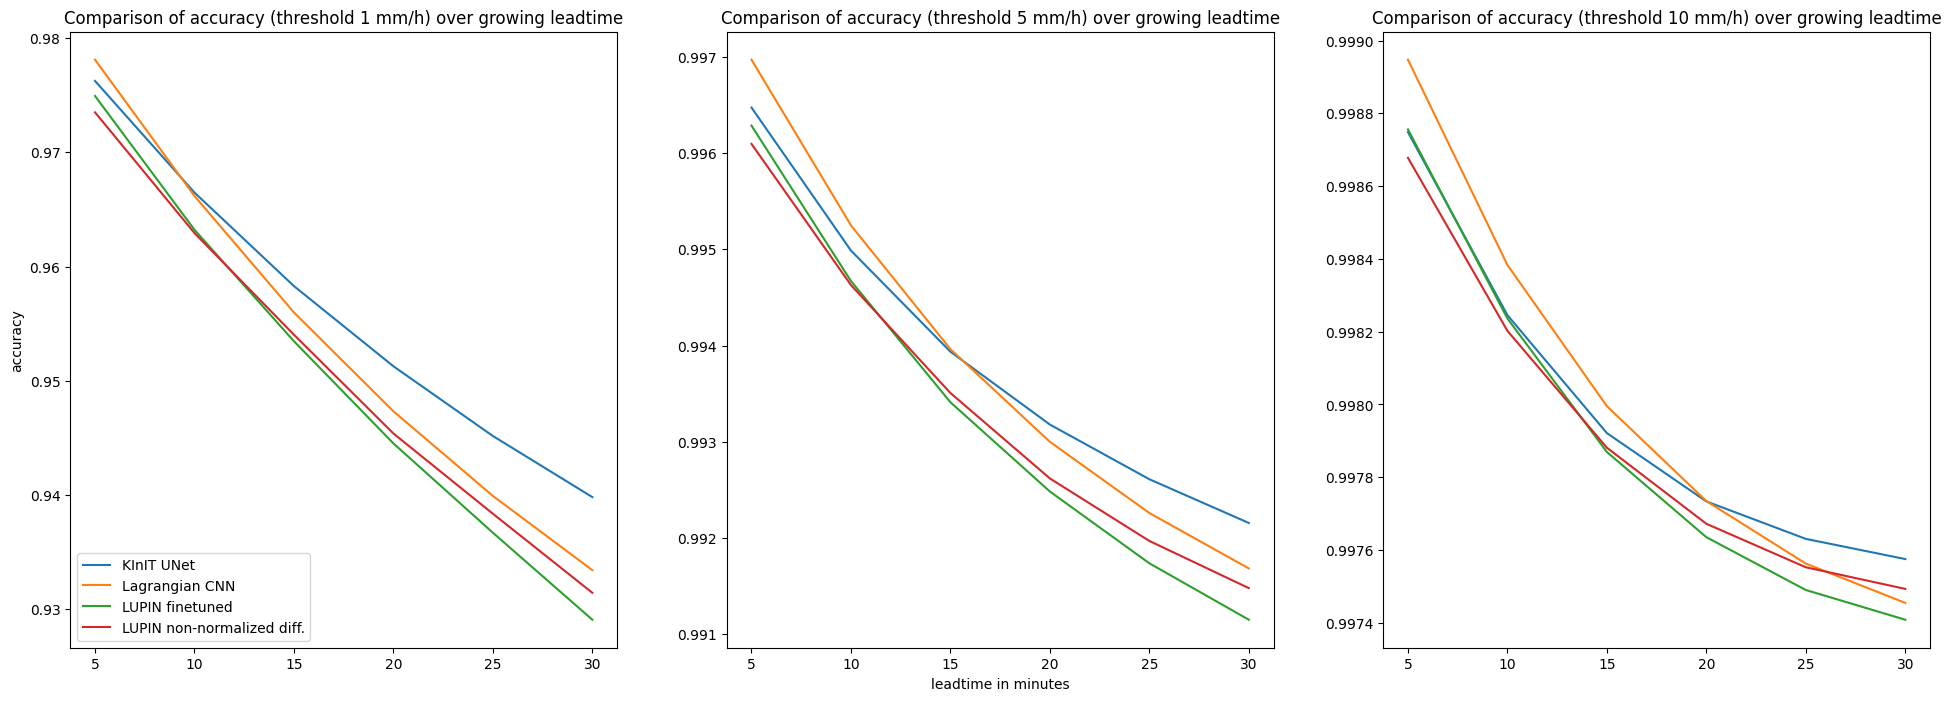

In [20]:
# accuracy plot
%matplotlib inline
x = [5,10,15,20,25,30]
fig, axes = plt.subplots(figsize=(24,8), nrows=1, ncols=3, gridspec_kw={'width_ratios': [8,8,8]})
for i, ax in enumerate(axes):
    #ax.plot(x, accuracy_sp[i,:], '-', label='extrapolation')
    #ax.plot(x, accuracy_ep[i,:], '-', label='s-prog')
    ax.plot(x, accuracy_nn[i,:], '-', label='KInIT UNet')
    ax.plot(x, accuracy_lc[i,:], label='Lagrangian CNN')
    #ax.plot(x, accuracy_mf[i,:], label='MF-U-Net')
    #ax.plot(x, accuracy_lupin[i,:], label='LUPIN')
    ax.plot(x, accuracy_lupin_ft[i,:], label='LUPIN finetuned')
    # ax.plot(x, accuracy_lupin_diff[i,:], label='LUPIN diff.')
    ax.plot(x, accuracy_lupin_ft_diff[i,:], label='LUPIN non-normalized diff.')

    ax.set_title(f'Comparison of accuracy (threshold {thresholds_mmh[i]} mm/h) over growing leadtime')

axes[0].set_ylabel("accuracy")  
axes[0].legend(loc="lower left")
axes[1].set_xlabel("leadtime in minutes")    
plt.show()

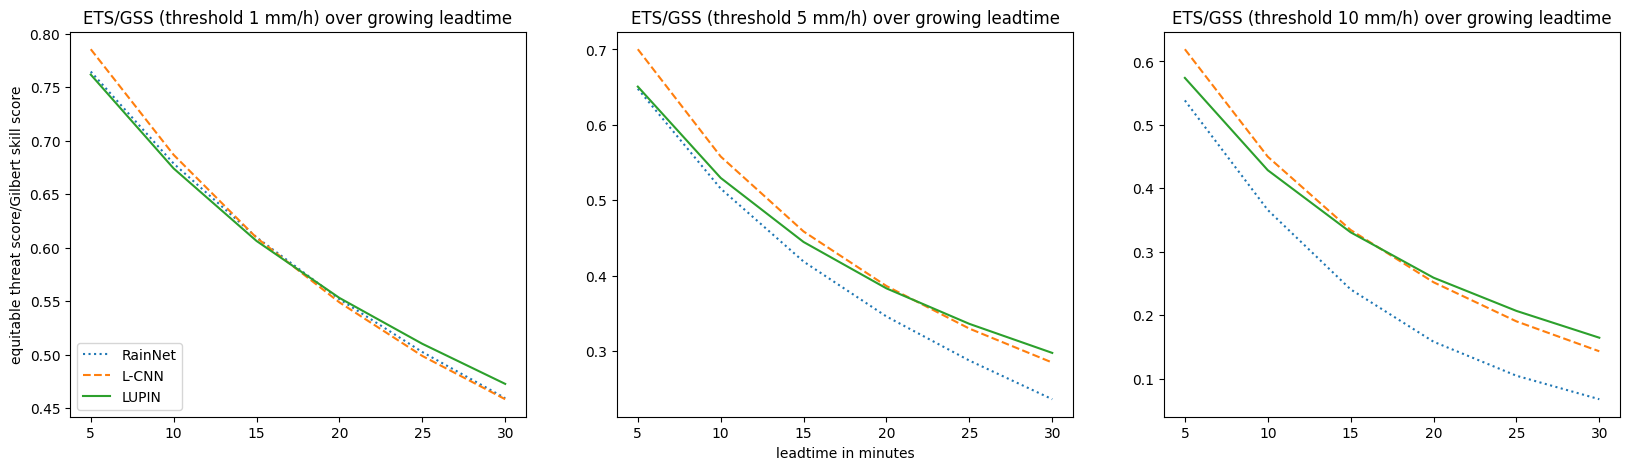

In [39]:
# ets/gss plot
%matplotlib inline
x = [5,10,15,20,25,30]
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=3, gridspec_kw={'width_ratios': [8,8,8]})
for i, ax in enumerate(axes):
    #ax.plot(x, ets_sp[i,:], '-', label='extrapolation')
    # ax.plot(x, ets_ep[i,:], '-', label='s-prog')
    ax.plot(x, ets_nn[i,:], ':', label='RainNet')
    ax.plot(x, ets_lc[i,:], '--', label='L-CNN')
    # ax.plot(x, ets_mf[i,:], label='MF-U-Net')
    #ax.plot(x, ets_lupin[i,:], label='LUPIN')
    ax.plot(x, ets_lupin_ft[i,:], label='LUPIN')
    #ax.plot(x, ets_lupin_diff[i,:], label='LUPIN diff.')
    #ax.plot(x, ets_lupin_ft_diff[i,:], label='LUPIN non-normalized diff.')

    ax.set_title(f'ETS/GSS (threshold {thresholds_mmh[i]} mm/h) over growing leadtime')

axes[0].set_ylabel("equitable threat score/Gilbert skill score")
axes[0].legend(loc="lower left")
axes[1].set_xlabel("leadtime in minutes")
#axes[0].set_yscale('log')
#axes[1].set_yscale('log')
#axes[2].set_yscale('log')
#axes[0].set_ylim(0.05,0.85)
#axes[1].set_ylim(0.05,0.85)
#axes[2].set_ylim(0.05,0.85)
plt.show()

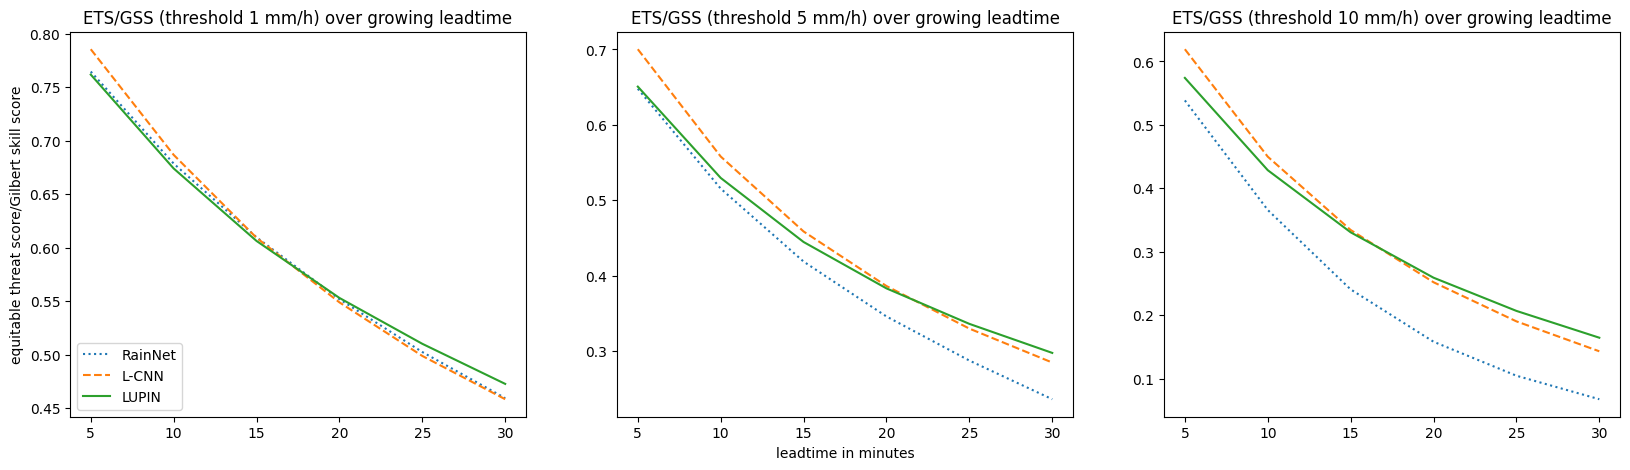

In [49]:
# ets/gss plot
%matplotlib inline
x = [5,10,15,20,25,30]
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=3, gridspec_kw={'width_ratios': [8,8,8]})
for i, ax in enumerate(axes):
    ax.plot(x, ets_nn[i,:], ':', label='RainNet')
    ax.plot(x, ets_lc[i,:], '--', label='L-CNN')
    ax.plot(x, ets_lupin[i,:], label='LUPIN')

    ax.set_title(f'ETS/GSS (threshold {thresholds_mmh[i]} mm/h) over growing leadtime')

axes[0].set_ylabel("equitable threat score/Gilbert skill score")
axes[0].legend(loc="lower left")
axes[1].set_xlabel("leadtime in minutes")
plt.show()

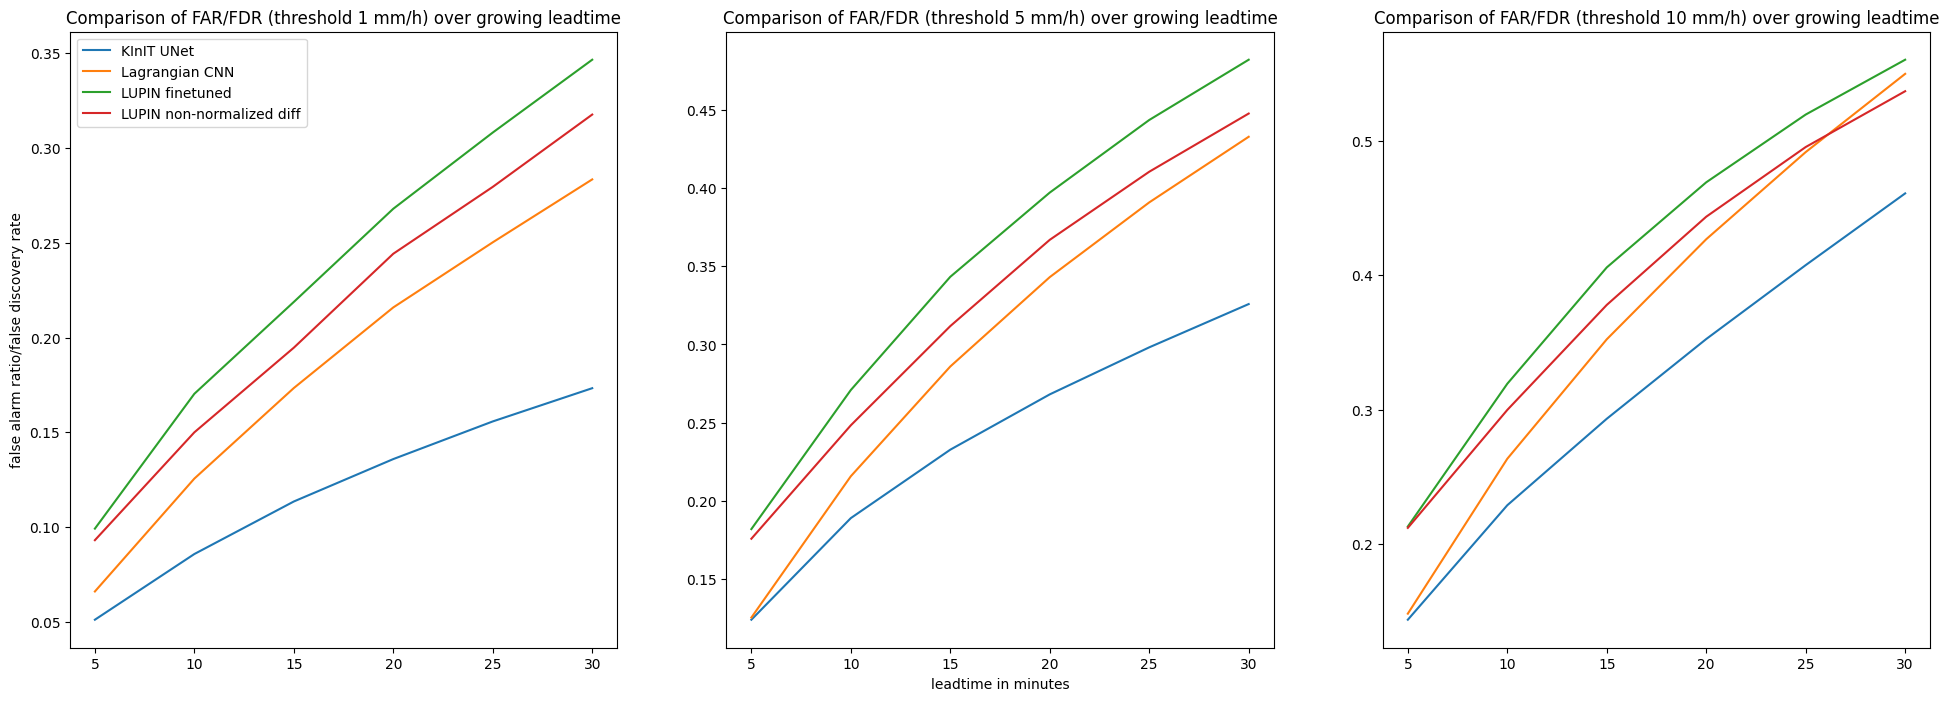

In [22]:
# far plot
%matplotlib inline
x = [5,10,15,20,25,30]
fig, axes = plt.subplots(figsize=(24,8), nrows=1, ncols=3, gridspec_kw={'width_ratios': [8,8,8]})
for i, ax in enumerate(axes):
    #ax.plot(x, far_sp[i,:], '-', label='extrapolation')
    #ax.plot(x, far_ep[i,:], '-', label='s-prog')
    ax.plot(x, far_nn[i,:], '-', label='KInIT UNet')
    ax.plot(x, far_lc[i,:], label='Lagrangian CNN')
    #ax.plot(x, far_mf[i,:], label='MF-U-Net')
    #ax.plot(x, far_lupin[i,:], label='LUPIN')
    ax.plot(x, far_lupin_ft[i,:], label='LUPIN finetuned')
    #ax.plot(x, far_lupin_diff[i,:], label='LUPIN diff')
    ax.plot(x, far_lupin_ft_diff[i,:], label='LUPIN non-normalized diff')

    ax.set_title(f'Comparison of FAR/FDR (threshold {thresholds_mmh[i]} mm/h) over growing leadtime')

axes[0].set_ylabel("false alarm ratio/false discovery rate")  
axes[0].legend(loc="upper left")
axes[1].set_xlabel("leadtime in minutes")    
plt.show()